## `rocky`

In [17]:
import os
mydir = r'C:\Users\aweaver\rocky\rocky-app\src\py'
# mydir = r'C:\Users\AndyW\OneDrive\Documents\GitHub\rocky\rocky-app\src\py'
os.chdir(mydir)
from rockycore import rocky
from triangle import Triangle

import pandas as pd
import numpy as np

In [18]:
# creat a new rocky object
r = rocky()

# inspect object
print(r)

rocky(id='rocky0', mod=("glm", "icrfs"), f=(), plot=(), t="paid_loss", rockylog=None)


In [19]:
# rename rocky object
r.rename('andys cool rocky object')
print(r)

rocky(id='andys cool rocky object', mod=("glm", "icrfs"), f=(), plot=(), t="paid_loss", rockylog=None)


In [20]:
# change name to something more descriptive
r.rename('rocky1')

## Could read in sample data (taylor_ashe, mack_1994) to try it out
# r.SampleTri('taylor_ashe')

## Could copy a triangle from a file to the clipboard and then read it in
# r.FromClipboard('paid_loss')

## for this demo, we'll just read in a triangle from a link ratio file

# triangle file path for WC 4Q2022
path = r'O:\STAFFHQ\SYMDATA\Actuarial\Reserving Applications\IBNR Allocation\4Q2022 Analysis\Workers Compensation 4Q2022.xlsb'

# read in triangle from file
r.FromExcel(path, 1, 'paid_loss', 'Gross Paid Ultimates', "a28:u48") # takes filepath, number of origin columns, name of triangle, sheet name, and range of triangle
print(r)

rocky(id='rocky1', mod=("glm", "icrfs"), f=(), plot=(), t="paid_loss", rockylog=None)


In [21]:
# r.TuneHyperparmeters()
# r.AddModel()
# r.Fit()
# r.model.PlotParameter()

In [22]:
# access triangle object
r.paid_loss

development_period           12            24        36        48        60  \
accident_period                                                               
2003-01-01          50330.00000  107898.00000  136945.0  153476.0  163446.0   
2004-01-01          56728.00000  118567.00000  147424.0  165383.0  177974.0   
2005-01-01          57102.00000  118436.00000  147933.0  167785.0  178853.0   
2006-01-01          63725.00000  135805.00000  171107.0  190146.0  201018.0   
2007-01-01          64449.00000  136478.00000  173430.0  193387.0  205651.0   
2008-01-01          68035.00000  145582.00000  181946.0  202926.0  217764.0   
2009-01-01          61673.00000  123776.00000  152108.0  166905.0  175113.0   
2010-01-01          63743.00000  125836.00000  153564.0  169391.0  180501.0   
2011-01-01          61631.00000  123717.00000  151484.0  166925.0  174995.0   
2012-01-01          59102.00000  115341.00000  140139.0  154009.0  162990.0   
2013-01-01          58997.00000  113350.00000  13664

In [23]:
r.AddModel('ll', 'loglinear', 'paid_loss')
r

This is for testing only.I do not recommend assigning much credibility to these estimates


rocky(id='rocky1', mod=("glm", "icrfs", "ll"), f=(), plot=(), t="paid_loss", rockylog=None)

In [25]:
r.ll.acc

0      2003
1      2004
2      2005
3      2006
4      2007
       ... 
341    2004
342    2005
360    2003
361    2004
380    2003
Name: accident_period, Length: 210, dtype: int32

In [8]:
# access dataframe representation of triangle object
r.paid_loss.tri.round(0)

development_period,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240
accident_period,,,,,,,,,,,,,,,,,,,,
2003-01-01,50330.0,107898.0,136945.0,153476.0,163446.0,170897.0,176694.0,179683.0,181314.0,182628.0,183684.0,184610.0,185183.0,185970.0,186695.0,187245.0,187945.0,188593.0,190049.0,190285.0
2004-01-01,56728.0,118567.0,147424.0,165383.0,177974.0,184788.0,189194.0,194049.0,197031.0,199073.0,200373.0,203933.0,205157.0,205872.0,206186.0,206744.0,207097.0,207341.0,208639.0,NaN
2005-01-01,57102.0,118436.0,147933.0,167785.0,178853.0,184737.0,189670.0,192074.0,193631.0,195255.0,196621.0,197400.0,198085.0,199019.0,199769.0,201215.0,201832.0,202066.0,NaN,NaN
2006-01-01,63725.0,135805.0,171107.0,190146.0,201018.0,209221.0,214884.0,219271.0,222141.0,226018.0,228246.0,230138.0,232340.0,233039.0,234316.0,234901.0,235986.0,NaN,NaN,NaN
2007-01-01,64449.0,136478.0,173430.0,193387.0,205651.0,211715.0,216153.0,218710.0,222250.0,223615.0,225497.0,227206.0,227881.0,229481.0,230098.0,230571.0,NaN,NaN,NaN,NaN
2008-01-01,68035.0,145582.0,181946.0,202926.0,217764.0,226280.0,230892.0,235734.0,238717.0,240135.0,241393.0,242397.0,242952.0,243311.0,243746.0,NaN,NaN,NaN,NaN,NaN
2009-01-01,61673.0,123776.0,152108.0,166905.0,175113.0,180130.0,184282.0,187589.0,188790.0,190638.0,191719.0,192974.0,193706.0,194419.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01,63743.0,125836.0,153564.0,169391.0,180501.0,187276.0,190278.0,192477.0,195197.0,196939.0,198366.0,198754.0,199674.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01,61631.0,123717.0,151484.0,166925.0,174995.0,179062.0,181316.0,183516.0,185931.0,186904.0,188619.0,189183.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# access linear design matrix:
r.paid_loss.X_base.head(10)

,is_observed,accident_period_2004,accident_period_2005,accident_period_2006,accident_period_2007,accident_period_2008,accident_period_2009,accident_period_2010,accident_period_2011,accident_period_2012,...,development_period_0132,development_period_0144,development_period_0156,development_period_0168,development_period_0180,development_period_0192,development_period_0204,development_period_0216,development_period_0228,development_period_0240
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
9,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# quick ATA factor summary
r.paid_loss.ata_summary()

Age-to-Age Factors as of (months),12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228
2003,2.144,1.269,1.121,1.065,1.046,1.034,1.017,1.009,1.007,1.006,1.005,1.003,1.004,1.004,1.003,1.004,1.003,1.008,1.001
2004,2.09,1.243,1.122,1.076,1.038,1.024,1.026,1.015,1.01,1.007,1.018,1.006,1.003,1.002,1.003,1.002,1.001,1.006,
2005,2.074,1.249,1.134,1.066,1.033,1.027,1.013,1.008,1.008,1.007,1.004,1.003,1.005,1.004,1.007,1.003,1.001,,
2006,2.131,1.26,1.111,1.057,1.041,1.027,1.02,1.013,1.017,1.01,1.008,1.01,1.003,1.005,1.002,1.005,,,
2007,2.118,1.271,1.115,1.063,1.029,1.021,1.012,1.016,1.006,1.008,1.008,1.003,1.007,1.003,1.002,,,,
2008,2.14,1.25,1.115,1.073,1.039,1.02,1.021,1.013,1.006,1.005,1.004,1.002,1.001,1.002,,,,,
2009,2.007,1.229,1.097,1.049,1.029,1.023,1.018,1.006,1.01,1.006,1.007,1.004,1.004,,,,,,
2010,1.974,1.22,1.103,1.066,1.038,1.016,1.012,1.014,1.009,1.007,1.002,1.005,,,,,,,
2011,2.007,1.224,1.102,1.048,1.023,1.013,1.012,1.013,1.005,1.009,1.003,,,,,,,,
2012,1.952,1.215,1.099,1.058,1.023,1.018,1.012,1.012,1.003,1.004,,,,,,,,,


In [11]:
# Triangle data type actually has a robust chain-ladder implementation that can be accessed

# this isn't important for right now, but it is there and it works well:
r.paid_loss.ult('vwa', 5, tail=1.061)

Accident Period
2003-01-01    201892.0
2004-01-01    221641.0
2005-01-01    216151.0
2006-01-01    252912.0
2007-01-01    247929.0
2008-01-01    262991.0
2009-01-01    210410.0
2010-01-01    216947.0
2011-01-01    206506.0
2012-01-01    191710.0
2013-01-01    188035.0
2014-01-01    179076.0
2015-01-01    150751.0
2016-01-01    162097.0
2017-01-01    134423.0
2018-01-01    148963.0
2019-01-01    146177.0
2020-01-01    105478.0
2021-01-01    117340.0
2022-01-01    112604.0
Name: Chain Ladder Ultimate Loss, dtype: float64

In [12]:
# now add a GLM model to the triangle:
r.AddModel('icrfs', 'loglinear', 'paid_loss')
print(r)

This is for testing only.I do not recommend assigning much credibility to these estimates
rocky(id='rocky1', mod=("glm", "icrfs"), f=(), plot=(), t="paid_loss", rockylog=None)


In [13]:
# load hyperparameters
# r.tweedie.TuneFitHyperparameters()
r.icrfs.SetHyperparameters(alpha=0.5, l1_ratio=0.5)
# r.tweedie.SetHyperparameters(alpha=0.2, power=2.3)
# r.tweedie.SetHyperparameters(alpha=1, power=1)
r.icrfs

loglinear(alpha=0.5, l1_ratio=0.5)

In [14]:
r.icrfs.GetY('train')
# r.icrfs.is_fitted

c:\users\AWEAVER\dat\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


0                inf
1                inf
2                inf
3                inf
4                inf
           ...      
341    9.286533e+105
342    4.216079e+101
360              inf
361              inf
380    3.115285e+102
Name: paid_loss, Length: 210, dtype: float64

In [15]:
## now that we have a set of hyperparameters, we can reuse them
## next time using model.SetHyperparameters(alpha, power):
# -> r.tweedie.SetHyperparameters(alpha=0.4, power=1.8)

# fit base model to the data
r.icrfs.Fit()
print(r)

c:\users\AWEAVER\dat\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Input y contains infinity or a value too large for dtype('float64').

In [ ]:
r.icrfs.model

ElasticNet(alpha=0.5, fit_intercept=False, max_iter=100000)

In [ ]:
r.icrfs.model.coef_

array([ 2.94369082,  1.65068136,  0.94852667,  0.61106443,  0.33712596,
        0.21382297,  0.14819288,  0.12054442,  0.0863156 ,  0.06378933,
        0.04705171,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.32996158,  0.25777067,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [ ]:
r.icrfs.PredictTriangle().pivot_table(index='accident_period', columns='development_period', values='yhat').round(0)

development_period,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240
accident_period,,,,,,,,,,,,,,,,,,,,
2003,19.0,72.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0
2004,99.0,374.0,484.0,484.0,484.0,484.0,484.0,484.0,484.0,484.0,484.0,484.0,484.0,484.0,484.0,484.0,484.0,484.0,484.0,484.0
2005,255.0,966.0,1250.0,1250.0,1250.0,1250.0,1250.0,1250.0,1250.0,1250.0,1250.0,1250.0,1250.0,1250.0,1250.0,1250.0,1250.0,1250.0,1250.0,1250.0
2006,471.0,1779.0,2302.0,2302.0,2302.0,2302.0,2302.0,2302.0,2302.0,2302.0,2302.0,2302.0,2302.0,2302.0,2302.0,2302.0,2302.0,2302.0,2302.0,2302.0
2007,659.0,2493.0,3225.0,3225.0,3225.0,3225.0,3225.0,3225.0,3225.0,3225.0,3225.0,3225.0,3225.0,3225.0,3225.0,3225.0,3225.0,3225.0,3225.0,3225.0
2008,816.0,3087.0,3994.0,3994.0,3994.0,3994.0,3994.0,3994.0,3994.0,3994.0,3994.0,3994.0,3994.0,3994.0,3994.0,3994.0,3994.0,3994.0,3994.0,3994.0
2009,947.0,3580.0,4632.0,4632.0,4632.0,4632.0,4632.0,4632.0,4632.0,4632.0,4632.0,4632.0,4632.0,4632.0,4632.0,4632.0,4632.0,4632.0,4632.0,4632.0
2010,1068.0,4038.0,5226.0,5226.0,5226.0,5226.0,5226.0,5226.0,5226.0,5226.0,5226.0,5226.0,5226.0,5226.0,5226.0,5226.0,5226.0,5226.0,5226.0,5226.0
2011,1164.0,4402.0,5697.0,5697.0,5697.0,5697.0,5697.0,5697.0,5697.0,5697.0,5697.0,5697.0,5697.0,5697.0,5697.0,5697.0,5697.0,5697.0,5697.0,5697.0


In [ ]:
r.paid_loss.incr_triangle.astype(float).round(0)

development_period,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240
accident_period,,,,,,,,,,,,,,,,,,,,
2003,50330.0,57568.0,29047.0,16531.0,9970.0,7451.0,5797.0,2989.0,1631.0,1314.0,1056.0,926.0,573.0,787.0,725.0,550.0,700.0,648.0,1456.0,236.0
2004,56728.0,61839.0,28857.0,17959.0,12591.0,6814.0,4406.0,4855.0,2982.0,2042.0,1300.0,3560.0,1224.0,715.0,314.0,558.0,353.0,244.0,1298.0,NaN
2005,57102.0,61334.0,29497.0,19852.0,11068.0,5884.0,4933.0,2404.0,1557.0,1624.0,1366.0,779.0,685.0,934.0,750.0,1446.0,617.0,234.0,NaN,NaN
2006,63725.0,72080.0,35302.0,19039.0,10872.0,8203.0,5663.0,4387.0,2870.0,3877.0,2228.0,1892.0,2202.0,699.0,1277.0,585.0,1085.0,NaN,NaN,NaN
2007,64449.0,72029.0,36952.0,19957.0,12264.0,6064.0,4438.0,2557.0,3540.0,1365.0,1882.0,1709.0,675.0,1600.0,617.0,473.0,NaN,NaN,NaN,NaN
2008,68035.0,77547.0,36364.0,20980.0,14838.0,8516.0,4612.0,4842.0,2983.0,1418.0,1258.0,1004.0,555.0,359.0,435.0,NaN,NaN,NaN,NaN,NaN
2009,61673.0,62103.0,28332.0,14797.0,8208.0,5017.0,4152.0,3307.0,1201.0,1848.0,1081.0,1255.0,732.0,713.0,NaN,NaN,NaN,NaN,NaN,NaN
2010,63743.0,62093.0,27728.0,15827.0,11110.0,6775.0,3002.0,2199.0,2720.0,1742.0,1427.0,388.0,920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,61631.0,62086.0,27767.0,15441.0,8070.0,4067.0,2254.0,2200.0,2415.0,973.0,1715.0,564.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
r.icrfs.train_index

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 200,
       201, 202, 203, 204, 205, 206, 207, 208, 209, 220, 221, 222, 223,
       224, 225, 226, 227, 228, 240, 241, 242, 243, 244, 245, 24

In [ ]:
r.icrfs.PearsonResiduals()

VarY is not implemented for this model.


NotImplementedError: 

In [ ]:
# chain ladder ult vs GLM
df = pd.concat([pd.DataFrame(r.paid_loss.ult()), pd.DataFrame(r.icrfs.Ultimate())], axis=1)
df = df.assign(Diff=df['Log-linear Ultimate'] - df['Chain Ladder Ultimate Loss']).astype(int)
df['Diagonal'] = r.paid_loss.diag().astype(int)
df['Unpaid'] = df['Log-linear Ultimate'] - df.Diagonal
df

,Chain Ladder Ultimate Loss,Log-linear Ultimate,Diff,Diagonal,Unpaid
Accident Period,,,,,
2003-01-01,190285,57379,-132906,190285,-132906
2004-01-01,208898,49765,-159133,208639,-158874
2005-01-01,203724,51125,-152599,202066,-150941
2006-01-01,238371,47534,-190837,235986,-188452
2007-01-01,233675,49884,-183791,230571,-180687
2008-01-01,247871,51576,-196295,243746,-192170
2009-01-01,198337,49213,-149124,194419,-145206
2010-01-01,204494,51368,-153126,199674,-148306
2011-01-01,194624,52062,-142562,189183,-137121


In [ ]:
r.icrfs.plot.obs_pred(log=True, color='dev')

In [ ]:
r.tweedie.plot.residual('acc', log=True)

In [ ]:
r.tweedie.plot.residual('dev', log=False)

In [ ]:
r.paid_loss.tri

development_period,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240
Accident Period,,,,,,,,,,,,,,,,,,,,
2003-01-01,50330.00000,107898.00000,136945.0,153476.0,163446.0,170897.0,176694.0,179683.0,181314.0,182628.0,183684.0,184610.0,185183.0,185970.0,186695.0,187245.0,187945.0,188593.0,190049.0,190285.0
2004-01-01,56728.00000,118567.00000,147424.0,165383.0,177974.0,184788.0,189194.0,194049.0,197031.0,199073.0,200373.0,203933.0,205157.0,205872.0,206186.0,206744.0,207097.0,207341.0,208639.0,NaN
2005-01-01,57102.00000,118436.00000,147933.0,167785.0,178853.0,184737.0,189670.0,192074.0,193631.0,195255.0,196621.0,197400.0,198085.0,199019.0,199769.0,201215.0,201832.0,202066.0,NaN,NaN
2006-01-01,63725.00000,135805.00000,171107.0,190146.0,201018.0,209221.0,214884.0,219271.0,222141.0,226018.0,228246.0,230138.0,232340.0,233039.0,234316.0,234901.0,235986.0,NaN,NaN,NaN
2007-01-01,64449.00000,136478.00000,173430.0,193387.0,205651.0,211715.0,216153.0,218710.0,222250.0,223615.0,225497.0,227206.0,227881.0,229481.0,230098.0,230571.0,NaN,NaN,NaN,NaN
2008-01-01,68035.00000,145582.00000,181946.0,202926.0,217764.0,226280.0,230892.0,235734.0,238717.0,240135.0,241393.0,242397.0,242952.0,243311.0,243746.0,NaN,NaN,NaN,NaN,NaN
2009-01-01,61673.00000,123776.00000,152108.0,166905.0,175113.0,180130.0,184282.0,187589.0,188790.0,190638.0,191719.0,192974.0,193706.0,194419.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01,63743.00000,125836.00000,153564.0,169391.0,180501.0,187276.0,190278.0,192477.0,195197.0,196939.0,198366.0,198754.0,199674.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01,61631.00000,123717.00000,151484.0,166925.0,174995.0,179062.0,181316.0,183516.0,185931.0,186904.0,188619.0,189183.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='Accident Period'>

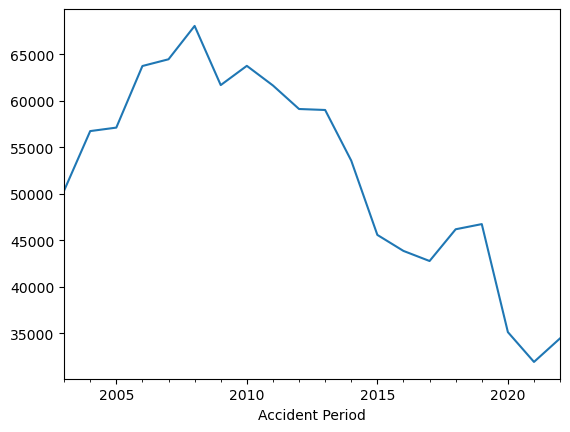

In [ ]:
## accident period parameters should roughly follow the first column:
r.paid_loss.tri.iloc[:, 0].plot()

In [ ]:
# but the actual fitted parameters include regularization terms that smooth out some of these bumps
r.tweedie.PlotParameter('acc')

In [ ]:
# does not include dev_period_0012 - first development period is assumed to be included in the first accident period parameter
r.tweedie.PlotParameter('dev')

In [ ]:
r.tweedie.Ultimate()

Accident Period
2003-01-01    188192.0
2004-01-01    202054.0
2005-01-01    206675.0
2006-01-01    220251.0
2007-01-01    218047.0
2008-01-01    220815.0
2009-01-01    194559.0
2010-01-01    197987.0
2011-01-01    189398.0
2012-01-01    177856.0
2013-01-01    205376.0
2014-01-01    174046.0
2015-01-01    156715.0
2016-01-01    149903.0
2017-01-01    144159.0
2018-01-01    155556.0
2019-01-01    140621.0
2020-01-01    121600.0
2021-01-01    125190.0
2022-01-01    123733.0
Name: GLM Ultimate, dtype: float64

In [ ]:
# final 2 accident years don't change much from 2020 - can set parameters for these years to be 0 (for no change)
r.tweedie.ManualFit(
  accident_period_2021=0, accident_period_2022=0,
  accident_period_2005=0,
  accident_period_2013=0,
  accident_period_2016=0,
  accident_period_2018=0
  )

In [ ]:
r.tweedie.PlotParameter('acc')

In [ ]:
r.tweedie.Ultimate()

Accident Period
2003-01-01    188348.0
2004-01-01    202204.0
2005-01-01    206818.0
2006-01-01    220393.0
2007-01-01    218216.0
2008-01-01    220906.0
2009-01-01    194614.0
2010-01-01    198046.0
2011-01-01    189464.0
2012-01-01    177940.0
2013-01-01    206266.0
2014-01-01    174464.0
2015-01-01    157229.0
2016-01-01    150188.0
2017-01-01    144478.0
2018-01-01    155888.0
2019-01-01    140811.0
2020-01-01    121795.0
2021-01-01    125355.0
2022-01-01    123971.0
Name: GLM Ultimate, dtype: float64

In [ ]:
## TODO
# - add a method to do a future calendar year projection
# - add a method to combine parameters into a single parameter for each year

In [ ]:
# add a second glm model that includes calendar year effects
r.AddModel('tweediecal', 'glm', 'paid_loss', cal=True)
print(r)

rocky(id='rocky1', mod=("tweedie", "tweediecal"), f=(), plot=(), t="paid_loss", rockylog=None)


In [ ]:
# can look at design matrix for this model -- it has 39 more columns for the 39 calendar periods in a 20x20 triangle
r.tweediecal.GetX()

,intercept,accident_period_2004,accident_period_2005,accident_period_2006,accident_period_2007,accident_period_2008,accident_period_2009,accident_period_2010,accident_period_2011,accident_period_2012,...,calendar_period_0030,calendar_period_0031,calendar_period_0032,calendar_period_0033,calendar_period_0034,calendar_period_0035,calendar_period_0036,calendar_period_0037,calendar_period_0038,calendar_period_0039
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,0,0
396,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,0,0
397,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
398,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0


In [ ]:
# using same hyperparameters as before, but could decide to refit
r.tweediecal.SetHyperparameters(alpha=0.3, power=1.8)
r.tweediecal

tweedieGLM(alpha=0.3, power=1.8)

In [ ]:
r.tweediecal.Fit()

In [ ]:
r.tweediecal.Ultimate()

Accident Period
2003-01-01    194280.0
2004-01-01    206745.0
2005-01-01    212257.0
2006-01-01    225428.0
2007-01-01    223951.0
2008-01-01    225211.0
2009-01-01    197511.0
2010-01-01    201818.0
2011-01-01    193107.0
2012-01-01    182434.0
2013-01-01    206633.0
2014-01-01    177032.0
2015-01-01    160941.0
2016-01-01    155491.0
2017-01-01    151186.0
2018-01-01    161333.0
2019-01-01    145918.0
2020-01-01    128059.0
2021-01-01    131724.0
2022-01-01    131359.0
Name: GLM Ultimate, dtype: float64

In [ ]:
r.tweediecal.PlotParameter('acc')

In [ ]:
r.tweediecal.PlotParameter('dev')

In [ ]:
r.tweediecal.PlotParameter('cal')

In [ ]:
## add a 1% future cal trend (eg assume that trend reverses itself)
future_cy_trend = 0.01
manfit = {}
for i in range(21, 40):
  manfit[f"calendar_period_00{i}"] = future_cy_trend

r.tweediecal.ManualFit(**manfit)

In [ ]:
r.tweediecal.PlotParameter('cal')

In [ ]:
r.tweediecal.Ultimate()

Accident Period
2003-01-01    195584.0
2004-01-01    207689.0
2005-01-01    213399.0
2006-01-01    226476.0
2007-01-01    225216.0
2008-01-01    226185.0
2009-01-01    198145.0
2010-01-01    202605.0
2011-01-01    193849.0
2012-01-01    183345.0
2013-01-01    207766.0
2014-01-01    177991.0
2015-01-01    162247.0
2016-01-01    156749.0
2017-01-01    152771.0
2018-01-01    162776.0
2019-01-01    147095.0
2020-01-01    129495.0
2021-01-01    133205.0
2022-01-01    133130.0
Name: GLM Ultimate, dtype: float64

In [ ]:
def parse_param_name(x):
  if x.find("_") == -1:
    return x
  else:
    end = x.split("_")[len(x.split("_"))-1]
    out = x.replace(f"_{end}", "")[:3]
    return out
  

df = pd.DataFrame(dict(nm=r.tweediecal.GetParameterNames(), val=r.tweediecal.model.coef_))
parse_param_name(df.nm[2])

'acc'

In [ ]:
df = pd.DataFrame({
  'chain ladder': r.paid_loss.ult(tail=1.05),
  'tweedie': r.tweedie.Ultimate(tail=1.05),
  'tweediecal': r.tweediecal.Ultimate(tail=1.05)
}).round(-3)/1000

df

,chain ladder,tweedie,tweediecal
Accident Period,,,
2003-01-01,200.0,198.0,205.0
2004-01-01,219.0,212.0,218.0
2005-01-01,214.0,217.0,224.0
2006-01-01,250.0,231.0,238.0
2007-01-01,245.0,229.0,236.0
2008-01-01,260.0,232.0,237.0
2009-01-01,208.0,204.0,208.0
2010-01-01,215.0,208.0,213.0
2011-01-01,204.0,199.0,204.0


In [ ]:
r.Add